In [133]:
import logging

# Configure logging
logging.basicConfig(
    level=logging.DEBUG,              # change to DEBUG for more details
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)

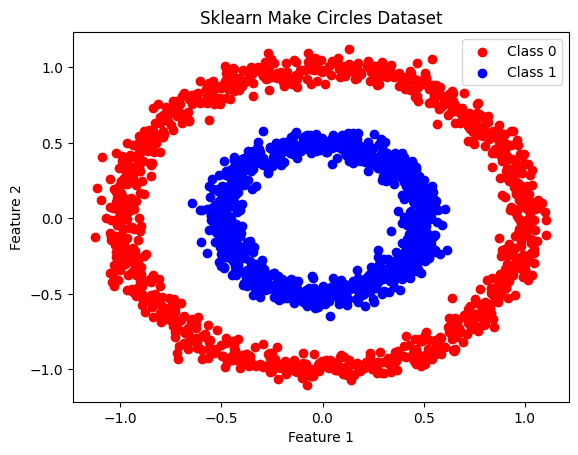

In [134]:
from sklearn.datasets import make_circles #Generated dataset
import matplotlib.pyplot as plt

# Generate a dataset with 200 samples and some noise
X, y = make_circles(n_samples=2000, noise=0.05, factor=0.5, random_state=42)

# Plot the dataset
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Sklearn Make Circles Dataset')
plt.legend()
plt.show()


In [135]:
import torch

# Convert the numpy arrays to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [136]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [137]:
len(X_train), len(X_test)

(1600, 400)

# Build a model to classify the data
 - Create a ```nn.Sequntial``` container
 - Concatenate 2 ```nn.Linear``` sub-modules



import ```torch.nn as nn```

In [138]:
import torch.nn as nn

In [139]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [140]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [141]:
CircleModel = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=1)
)

model = CircleModel
model = model.to(device=device)


In [142]:
next(model.parameters()).device

device(type='cpu')

In [143]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4762, -0.5216],
                      [-0.4113,  0.1349],
                      [-0.2161,  0.1294],
                      [-0.1767, -0.3386],
                      [-0.0787,  0.2904]])),
             ('0.bias', tensor([-0.1829,  0.6037, -0.6934,  0.4251,  0.5594])),
             ('2.weight',
              tensor([[ 0.0076, -0.0406,  0.2077, -0.3149, -0.1812]])),
             ('2.bias', tensor([-0.2644]))])

In [144]:
list(model.parameters())
sum(p.abs().sum().item() for p in model.parameters())
[p.grad for p in model.parameters()]

[None, None, None, None]

In [145]:
# Test the model
with torch.inference_mode():
    y_preds_unrtained = model(X_train)

In [146]:
torch.sigmoid(y_preds_unrtained).round().sum()/len(y_preds_unrtained)

tensor(0.)

In [147]:
((y_preds_unrtained > 0.0) == y_train).float().mean()

tensor(0.5019)

In [148]:
y_pred_labels = torch.round(torch.sigmoid(y_preds_unrtained))
torch.eq(y_pred_labels.squeeze(), y_train.squeeze())

tensor([ True,  True, False,  ...,  True, False,  True])

# Use `nn.BCEWithLogitLoss()` function for calculating losses

In [149]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

# Define an accuracy function metric

In [150]:
def accuracy_fn(y_true, y_pred):
  assert y_true.ndim == y_pred.ndim == 1 and len(y_true) == len(y_pred), 'The pred and true values must be 1D and of same length'
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

# Train the model

In [151]:
import sys
def trainModel(numepochs):

  trainloss = []
  testloss = []
  trainacc = []
  testacc = []

  for epochi in range(numepochs):
    model.train()
    y_preds = model(X_train).squeeze()

    train_loss = loss_fn(y_preds, y_train)
    trainloss.append(train_loss.detach())

    train_acc = accuracy_fn(y_train,
                            torch.round(torch.sigmoid(y_preds)))

    trainacc.append(train_acc)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()


    model.eval()
    with torch.inference_mode():
      test_preds = model(X_test).squeeze()

    test_loss = loss_fn(test_preds, y_test)
    testloss.append(test_loss.detach())

    test_acc = accuracy_fn(y_test, torch.round(torch.sigmoid(test_preds)))
    testacc.append(test_acc)

    # if epochi % 100 == 0:
    #   sys.stdout.write(f'\nEpoch: {epochi} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}')

  return trainloss, testloss, trainacc, testacc

In [152]:
# def trainModel(numepochs):
#     model.train()  # good starting state
#     trainloss, testloss, trainacc, testacc = [], [], [], []

#     for epochi in range(numepochs):
#         # ----- TRAIN -----
#         model.train()
#         y_preds = model(X_train)  # logits

#         train_loss = loss_fn(y_preds, y_train.float().unsqueeze(1))
#         optimizer.zero_grad(set_to_none=True)
#         train_loss.backward()

#         # debug: gradient norm
#         total_grad = 0.0
#         num_t = 0
#         for p in model.parameters():
#             if p.grad is not None:
#                 total_grad += p.grad.detach().abs().mean().item()
#                 num_t += 1
#         grad_mean = total_grad / max(1, num_t)

#         # debug: param checksum before step
#         with torch.no_grad():
#             param_checksum_before = sum(p.abs().sum().item() for p in model.parameters())

#         optimizer.step()

#         # debug: param checksum after step
#         with torch.no_grad():
#             param_checksum_after = sum(p.abs().sum().item() for p in model.parameters())

#         # accuracy (use sigmoid only here)
#         with torch.no_grad():
#             train_pred_bin = torch.round(torch.sigmoid(y_preds)).squeeze()
#             train_acc = accuracy_fn(y_train.squeeze(), train_pred_bin)

#         trainloss.append(train_loss.item())
#         trainacc.append(train_acc)

#         # ----- EVAL -----
#         model.eval()
#         with torch.inference_mode():
#             test_logits = model(X_test)
#             test_loss = loss_fn(test_logits, y_test.float().unsqueeze(1))
#             test_pred_bin = torch.round(torch.sigmoid(test_logits)).squeeze()
#             test_acc = accuracy_fn(y_test.squeeze(), test_pred_bin)

#         testloss.append(test_loss.item())
#         testacc.append(test_acc)

#         if epochi % 100 == 0:
#             print(f"Epoch {epochi:03d} | "
#                   f"TrL: {train_loss.item():.4f} TrA: {train_acc:.3f} | "
#                   f"TeL: {test_loss.item():.4f} TeA: {test_acc:.3f} | "
#                   f"grad_mean: {grad_mean:.3e} | "
#                   f"dParam: {(param_checksum_after - param_checksum_before):.3e}")

#     return trainloss, testloss, trainacc, testacc


In [153]:
trainloss, testloss, trainacc, testacc = trainModel(50000)


Epoch: 0 | Train Loss: 0.727 | Train Acc: 50.19 | Test Loss: 0.732 | Test Acc: 49.25
Epoch: 100 | Train Loss: 0.706 | Train Acc: 50.19 | Test Loss: 0.709 | Test Acc: 49.25
Epoch: 200 | Train Loss: 0.697 | Train Acc: 50.19 | Test Loss: 0.700 | Test Acc: 49.25
Epoch: 300 | Train Loss: 0.694 | Train Acc: 50.19 | Test Loss: 0.696 | Test Acc: 49.25
Epoch: 400 | Train Loss: 0.692 | Train Acc: 50.19 | Test Loss: 0.694 | Test Acc: 49.25
Epoch: 500 | Train Loss: 0.691 | Train Acc: 38.62 | Test Loss: 0.692 | Test Acc: 36.50
Epoch: 600 | Train Loss: 0.690 | Train Acc: 43.31 | Test Loss: 0.691 | Test Acc: 43.00
Epoch: 700 | Train Loss: 0.689 | Train Acc: 48.50 | Test Loss: 0.690 | Test Acc: 48.50
Epoch: 800 | Train Loss: 0.688 | Train Acc: 50.25 | Test Loss: 0.689 | Test Acc: 50.50
Epoch: 900 | Train Loss: 0.687 | Train Acc: 51.25 | Test Loss: 0.688 | Test Acc: 51.25
Epoch: 1000 | Train Loss: 0.686 | Train Acc: 52.38 | Test Loss: 0.687 | Test Acc: 52.25
Epoch: 1100 | Train Loss: 0.685 | Train Acc

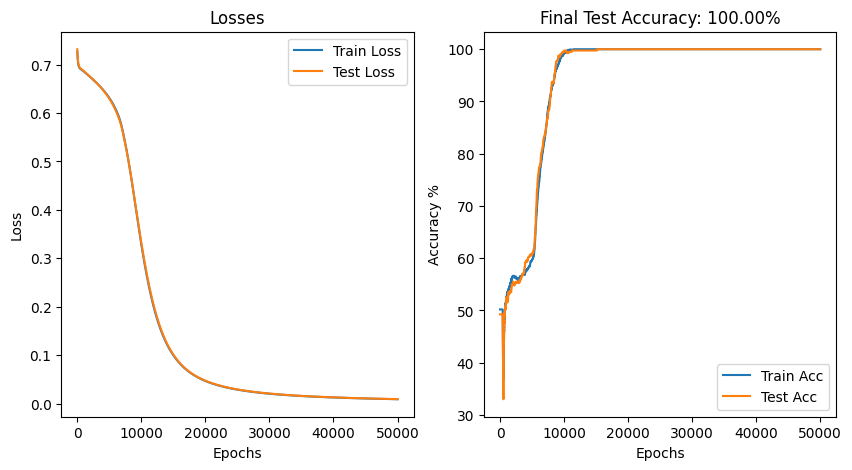

In [154]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot losses
ax[0].plot(trainloss, label='Train Loss')
ax[0].plot(testloss, label='Test Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Losses')

# Plot accuracy
ax[1].plot(trainacc, label='Train Acc')
ax[1].plot(testacc, label='Test Acc')
ax[1].legend()
ax[1].set_title(f'Final Test Accuracy: {testacc[-1]:.2f}%')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy %')

plt.show();

# Final Predictions and Visualization

In [170]:
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
xx.shape, yy.shape

((101, 101), (101, 101))

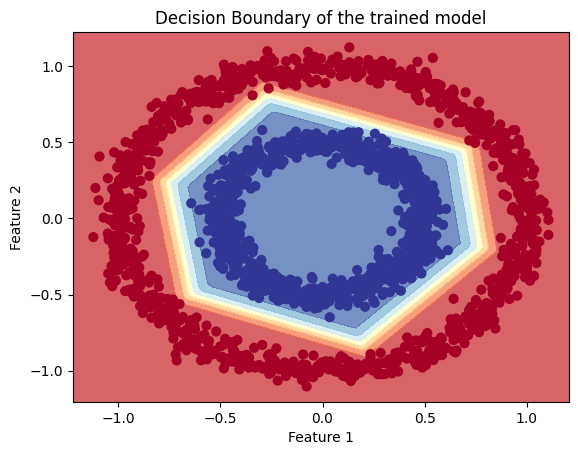

In [174]:
import numpy as np

# Setup prediction boundaries and grid
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

# Make predictions on the grid
model.eval()
with torch.inference_mode():
    y_grid_preds = torch.sigmoid(model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device))).cpu().numpy()


# Reshape preds and plot
y_grid_preds = y_grid_preds.reshape(xx.shape)
plt.contourf(xx, yy, y_grid_preds, cmap=plt.cm.RdYlBu, alpha=0.7)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Decision Boundary of the trained model")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()